This notebook provides an overview of the 
outputs we envision receiving from each modelling
team for fastMIPT phase 2. The dataframe and 
plots were generated with trial data available
through the PROVIDE project and do not reflect
actual CMIP7-related data. We used annaul temperature
data to generate these sample dataframes and would like
to receive the output in this format for any 
variable you emulate. Each section walks you
through a particular output format. Please let
me know if you have any questions. 

In [1]:
# -------------------------
# Packages
# -------------------------
import xarray as xr
import pandas as pd
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
from pathlib import Path
import cartopy.crs as ccrs
from glob import glob

import regionmask

In [2]:
# -------------------------
# PARAMETERS & PATHS
# -------------------------
PATH_SAMPLE_OUTPUT_FASTMIP = Path('/net/exo/landclim/scsarah/data/fastMIP/sample_output_from_provide_data/')

SCENARIOS = ['ssp119', 'SP', 'Ref', 'LD', 'GS', 'ModAct', 'CurPol']
sel_scenario = 'ModAct' # example scenario, used whenever single-scenario data is plotted

SCEN_STORING_PATH = PATH_SAMPLE_OUTPUT_FASTMIP / sel_scenario # scenario-specific data should be stored in a sub-folder within the overall output folder

# selecting some grid-cell in France for illustrative purposes
sel_lat = 46.25
sel_lon = 3.75

# selecting some ESM for illustrative purposes
sel_mesmer_esm_calibration = 'ACCESS-ESM1-5'

selected_regions = [-1, 34, 17] # region keys for global, Tibetean Plateau, and Western Central Europe, see explanation in section 4.

## 1. Output: Sample realisations
This is a scenario-specific file containing 10 realisations for each ESM. Your underlying dataset can be much larger, in which case you can randomly select 10 realisations from it. Note, that the selected realisations should be consistent across variables (e.g., if your model can jointly emulate multiple variable, such as temperature and precipitation, the random subselection should be applied to both variables simultaneously to conserve cross-variale correlations). 

In [3]:
# loading actual realisations
sample_realisations_file = SCEN_STORING_PATH / f'{sel_scenario}_TAS_GRIDCELL_selected-realisations.nc'

tas = xr.open_dataarray(sample_realisations_file)
print(tas)
# the data is on a regular lat-long grid (2.5 x 2.5 degrees)
# and contains realisations for each of the 25 (or 5, for tier 1) ESMs
# the unused variable 'fair_scenario' indicates the underlying scenario
# in our case ModAct

<xarray.DataArray 'tas' (mesmer_esm_calibration: 25, realisation: 10, year: 86,
                         lat: 56, lon: 143)> Size: 1GB
[172172000 values with dtype=float64]
Coordinates:
  * lat                     (lat) float64 448B -53.75 -51.25 ... 81.25 83.75
  * lon                     (lon) float64 1kB -178.8 -176.2 ... 176.2 178.8
  * mesmer_esm_calibration  (mesmer_esm_calibration) <U15 2kB 'ACCESS-CM2' .....
  * year                    (year) int64 688B 2015 2016 2017 ... 2098 2099 2100
  * realisation             (realisation) int64 80B 0 1 2 3 4 5 6 7 8 9
    fair_scenario           <U6 24B ...


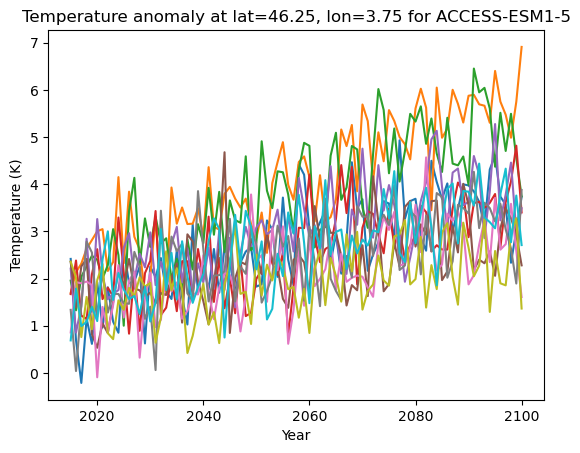

In [4]:
plt.figure()
plt.plot(tas['year'].values, tas.sel(lat=sel_lat, lon=sel_lon, mesmer_esm_calibration = sel_mesmer_esm_calibration ).values.T)
plt.xlabel('Year')
plt.ylabel('Temperature (K)')  # Assuming the data is temperature in Kelvin
plt.title(f'Temperature anomaly at lat={sel_lat}, lon={sel_lon} for {sel_mesmer_esm_calibration}')
plt.show()

## 2. Output: Aggregated statistics by gridcell and ESM
This is a scenario-specific file containing mean data and quantiles 
computed independently at each gridcell and independently for each model.
This represents the spread within each ESM

In [5]:
# loading aggregated quantities
quantiles_gridcell_file = SCEN_STORING_PATH / f'{sel_scenario}_TAS_GRIDCELL_QUANTILES-by-ESM.nc'

ds = xr.open_dataset(quantiles_gridcell_file)
print(ds)
# the data is on a regular lat-long grid (2.5 x 2.5 degrees)
# and contains aggregated quantiles (here called tas)
# and mean values (here called tas_mean)
# the values are computed independently for each ESM

<xarray.Dataset> Size: 1GB
Dimensions:                 (lat: 56, lon: 143, year: 86, quantile: 9,
                             mesmer_esm_calibration: 25)
Coordinates:
  * lat                     (lat) float64 448B -53.75 -51.25 ... 81.25 83.75
  * lon                     (lon) float64 1kB -178.8 -176.2 ... 176.2 178.8
  * year                    (year) int64 688B 2015 2016 2017 ... 2098 2099 2100
  * quantile                (quantile) float64 72B 0.01 0.025 ... 0.975 0.99
  * mesmer_esm_calibration  (mesmer_esm_calibration) <U15 2kB 'ACCESS-CM2' .....
    fair_scenario           <U6 24B ...
Data variables:
    tas                     (quantile, mesmer_esm_calibration, year, lat, lon) float64 1GB ...
    tas_mean                (mesmer_esm_calibration, year, lat, lon) float64 138MB ...


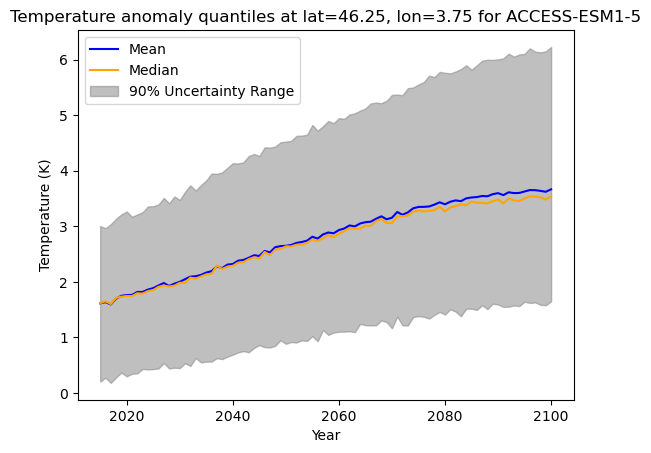

In [6]:
# for example, plotting the median and mean temperature anomaly
# along with the 90% uncertainty range for the selected grid-cell
# and ESM
plt.figure()
plt.plot(ds['year'].values, ds['tas_mean'].sel(lat=sel_lat, lon=sel_lon, mesmer_esm_calibration = sel_mesmer_esm_calibration ).values, label='Mean', color='blue')
plt.plot(ds['year'].values, ds['tas'].sel(lat=sel_lat, lon=sel_lon, quantile=0.5, mesmer_esm_calibration = sel_mesmer_esm_calibration ).values, label='Median', color='orange')
plt.fill_between(ds['year'].values,
                 ds['tas'].sel(lat=sel_lat, lon=sel_lon, quantile=0.05, mesmer_esm_calibration = sel_mesmer_esm_calibration ).values,
                 ds['tas'].sel(lat=sel_lat, lon=sel_lon, quantile=0.95, mesmer_esm_calibration = sel_mesmer_esm_calibration ).values,
                 color='gray', alpha=0.5, label='90% Uncertainty Range')
plt.xlabel('Year')
plt.ylabel('Temperature (K)')  # Assuming the data is temperature in Kelvin
plt.title(f'Temperature anomaly quantiles at lat={sel_lat}, lon={sel_lon} for {sel_mesmer_esm_calibration}')
plt.legend()
plt.show()

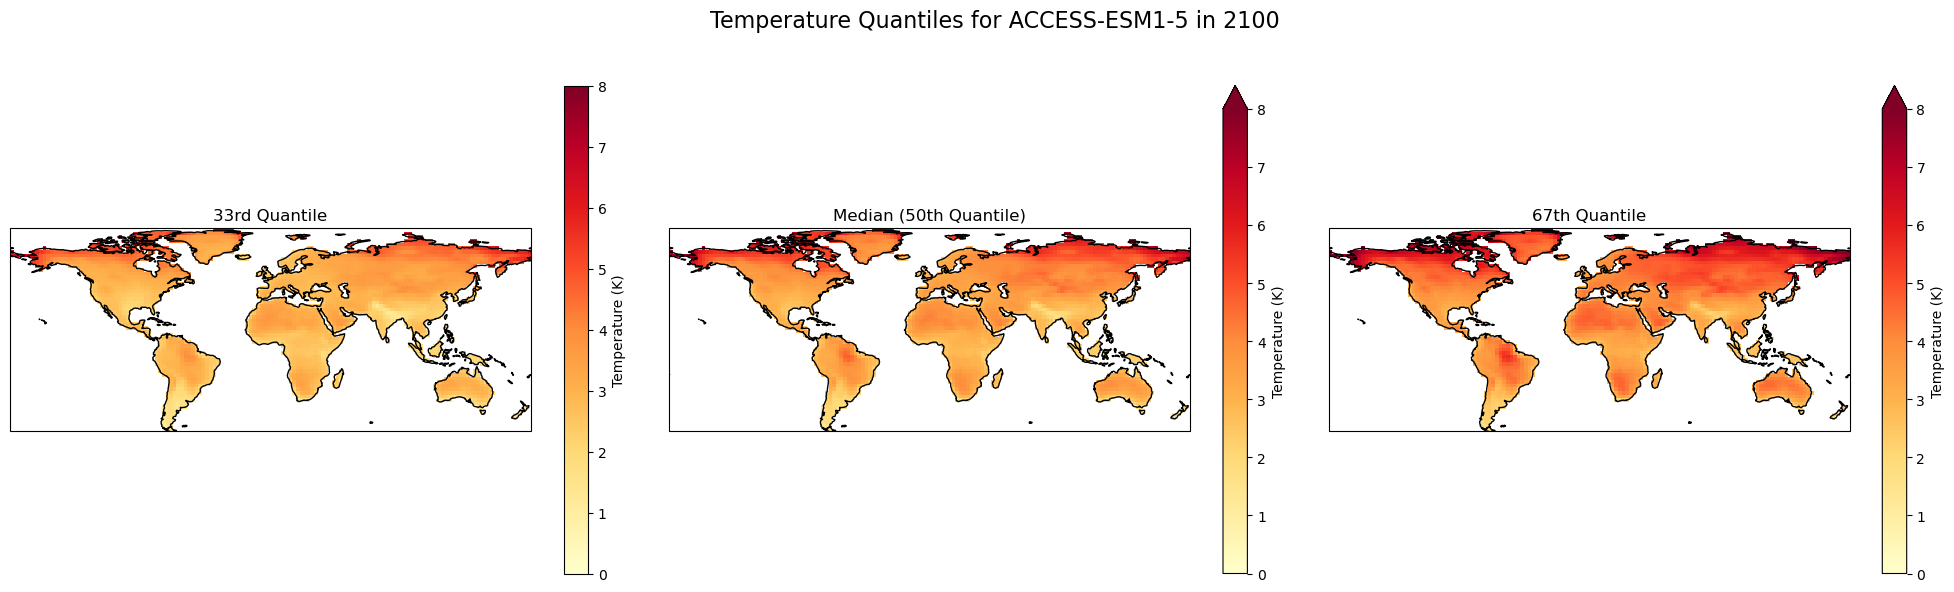

In [7]:
# Generate maps for the 33rd, median, and 67th quantiles for the selected ESM and year 2100
quantiles_to_plot = [0.33, 0.5, 0.67]
titles = ['33rd Quantile', 'Median (50th Quantile)', '67th Quantile']
cmap = 'YlOrRd'

fig, axes = plt.subplots(1, 3, figsize=(20, 6), subplot_kw={'projection': ccrs.PlateCarree()})

for ax, quantile, title in zip(axes, quantiles_to_plot, titles):
    data = ds['tas'].sel(quantile=quantile, mesmer_esm_calibration=sel_mesmer_esm_calibration, year=2100)
    data.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        cbar_kwargs={"label": "Temperature (K)"},
        vmin = 0,
        vmax = 8
    )
    ax.coastlines()
    ax.set_title(title)

fig.suptitle(f'Temperature Quantiles for {sel_mesmer_esm_calibration} in 2100', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the suptitle
plt.show()


## 3. Output: Aggregated statistics by gridcell *across* ESMs
This is a scenario-specific file containing mean data and quantiles 
computed independently at each gridcell, but across all models.
It should reflect the multi-model ensemble spreads.

In [8]:
# loading aggregated quantities computed across ESMs
quantiles_gridcell_file = SCEN_STORING_PATH / f'{sel_scenario}_TAS_GRIDCELL_QUANTILES-across-ESM.nc'

ds = xr.open_dataset(quantiles_gridcell_file)
print(ds)
# the data is on a regular lat-long grid (2.5 x 2.5 degrees)
# and contains aggregated quantiles (here called tas)
# and mean values (here called tas_mean); in contrast to
# the previous dataset, these quantities represent
# aggregates across ESMs, so there is no ESM dimension anymore

<xarray.Dataset> Size: 55MB
Dimensions:        (lat: 56, lon: 143, year: 86, quantile: 9)
Coordinates:
  * lat            (lat) float64 448B -53.75 -51.25 -48.75 ... 78.75 81.25 83.75
  * lon            (lon) float64 1kB -178.8 -176.2 -173.8 ... 173.8 176.2 178.8
  * year           (year) int64 688B 2015 2016 2017 2018 ... 2097 2098 2099 2100
  * quantile       (quantile) float64 72B 0.01 0.025 0.05 ... 0.95 0.975 0.99
    fair_scenario  <U6 24B ...
Data variables:
    tas            (quantile, year, lat, lon) float64 50MB ...
    tas_mean       (year, lat, lon) float64 6MB ...


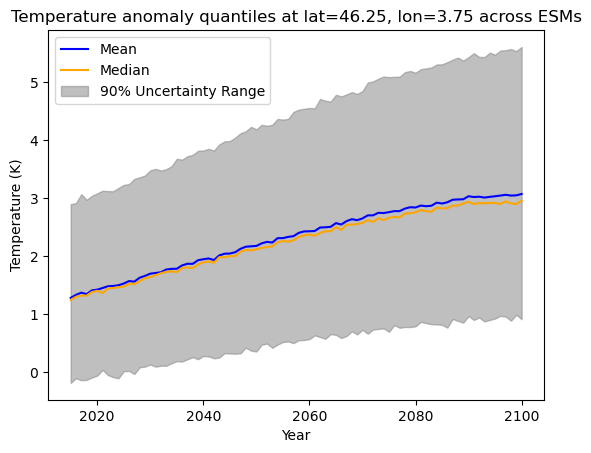

In [9]:
# for example, plotting the median and mean temperature anomaly
# along with the 90% uncertainty range computed across ESMs
# for the selected grid-cell

plt.figure()
plt.plot(ds['year'].values, ds['tas_mean'].sel(lat=sel_lat, lon=sel_lon).values, label='Mean', color='blue')
plt.plot(ds['year'].values, ds['tas'].sel(lat=sel_lat, lon=sel_lon, quantile=0.5).values, label='Median', color='orange')
plt.fill_between(ds['year'].values,
                 ds['tas'].sel(lat=sel_lat, lon=sel_lon, quantile=0.05).values,
                 ds['tas'].sel(lat=sel_lat, lon=sel_lon, quantile=0.95).values,
                 color='gray', alpha=0.5, label='90% Uncertainty Range')
plt.xlabel('Year')
plt.ylabel('Temperature (K)')  # Assuming the data is temperature in Kelvin
plt.title(f'Temperature anomaly quantiles at lat={sel_lat}, lon={sel_lon} across ESMs')
plt.legend()
plt.show()

## 4. Output: Aggregated statistics by *region* and *ESM*
This is the same as the output described in 2., only the gridcell-level
data is aggregated to regional level by computing area-weighted means 
and then the overall statistics are computed. 
Regions as defined in regionmask package AR6 land, only a global-land
average was added with maks key -1. 

In [10]:
quantiles_region_file = SCEN_STORING_PATH / f'{sel_scenario}_TAS_REGIONAL_QUANTILES-by-ESM.nc'

ds = xr.open_dataset(quantiles_region_file)
print(ds)
# the data contains regionaly aggregated variables
# (quantiles called tas and mean values called tas_mean);
# these are resolved by ESM as in 2.
# regions follow AR6 land (https://regionmask.readthedocs.io/en/stable/defined_scientific.html)
# an additional global region containing area-weighted global
# means was added with value -1 in mask.

<xarray.Dataset> Size: 8MB
Dimensions:                 (year: 86, mask: 45, quantile: 9,
                             mesmer_esm_calibration: 25)
Coordinates:
  * year                    (year) int64 688B 2015 2016 2017 ... 2098 2099 2100
  * mask                    (mask) float64 360B 0.0 1.0 2.0 ... 42.0 43.0 -1.0
  * quantile                (quantile) float64 72B 0.01 0.025 ... 0.975 0.99
  * mesmer_esm_calibration  (mesmer_esm_calibration) <U15 2kB 'ACCESS-CM2' .....
    fair_scenario           <U6 24B ...
Data variables:
    tas                     (quantile, mesmer_esm_calibration, year, mask) float64 7MB ...
    tas_mean                (mesmer_esm_calibration, year, mask) float64 774kB ...


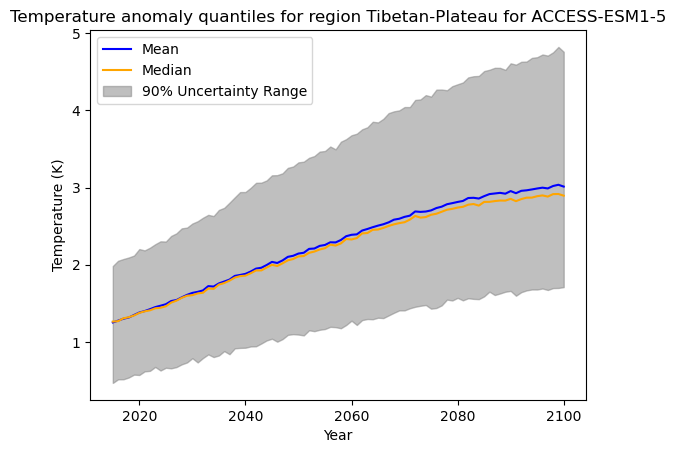

In [11]:
# for example, plotting the median and mean temperature anomaly
# along with the 90% uncertainty range for a selected region
# and ESM
sel_mask = selected_regions[1]  # selecting a region
region_name = regionmask.defined_regions.ar6.land[sel_mask].name # getting the name of the region

plt.figure()
plt.plot(ds['year'].values, ds['tas_mean'].sel(mask = sel_mask, mesmer_esm_calibration = sel_mesmer_esm_calibration ).values, label='Mean', color='blue')
plt.plot(ds['year'].values, ds['tas'].sel(mask = sel_mask, quantile=0.5, mesmer_esm_calibration = sel_mesmer_esm_calibration ).values, label='Median', color='orange')
plt.fill_between(ds['year'].values,
                 ds['tas'].sel(mask = sel_mask, quantile=0.05, mesmer_esm_calibration = sel_mesmer_esm_calibration ).values,
                 ds['tas'].sel(mask = sel_mask, quantile=0.95, mesmer_esm_calibration = sel_mesmer_esm_calibration ).values,
                 color='gray', alpha=0.5, label='90% Uncertainty Range')
plt.xlabel('Year')
plt.ylabel('Temperature (K)')  # Assuming the data is temperature in Kelvin
plt.title(f'Temperature anomaly quantiles for region {region_name} for {sel_mesmer_esm_calibration}')
plt.legend()
plt.show()

## 5. Output: Aggregated statistics by *region* *across* ESM
This is the same as the output described in 3., only the gridcell-level
data is aggregated to regional level by computing area-weighted means 
and then the overall statistics are computed. 
Regions as defined in regionmask package AR6 land, only a global-land
average was added with maks key -1. 

In [12]:
quantiles_region_file = SCEN_STORING_PATH / f'{sel_scenario}_TAS_REGIONAL_QUANTILES-across-ESM.nc'

ds = xr.open_dataset(quantiles_region_file)
print(ds)
# the data contains regionaly aggregated variables
# (quantiles called tas and mean values called tas_mean);
# these are computed across ESM as in 3.
# regions follow AR6 land (https://regionmask.readthedocs.io/en/stable/defined_scientific.html)
# an additional global region containing area-weighted global
# means was added with value -1 in mask.

<xarray.Dataset> Size: 311kB
Dimensions:        (year: 86, mask: 45, quantile: 9)
Coordinates:
  * year           (year) int64 688B 2015 2016 2017 2018 ... 2097 2098 2099 2100
  * mask           (mask) float64 360B 0.0 1.0 2.0 3.0 ... 41.0 42.0 43.0 -1.0
  * quantile       (quantile) float64 72B 0.01 0.025 0.05 ... 0.95 0.975 0.99
    fair_scenario  <U6 24B ...
Data variables:
    tas            (quantile, year, mask) float64 279kB ...
    tas_mean       (year, mask) float64 31kB ...


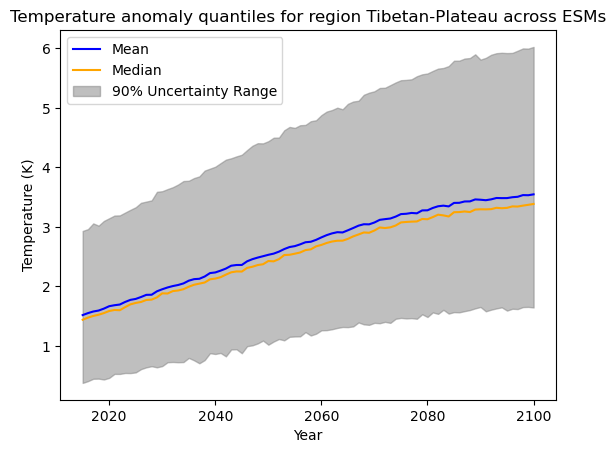

In [13]:
# for example, plotting the median and mean temperature anomaly
# along with the 90% uncertainty range computed across models
# for a selected region
sel_mask = selected_regions[1]  # selecting a region
region_name = regionmask.defined_regions.ar6.land[sel_mask].name # getting the name of the region

plt.figure()
plt.plot(ds['year'].values, ds['tas_mean'].sel(mask = sel_mask).values, label='Mean', color='blue')
plt.plot(ds['year'].values, ds['tas'].sel(mask = sel_mask, quantile=0.5).values, label='Median', color='orange')
plt.fill_between(ds['year'].values,
                 ds['tas'].sel(mask = sel_mask, quantile=0.05).values,
                 ds['tas'].sel(mask = sel_mask, quantile=0.95).values,
                 color='gray', alpha=0.5, label='90% Uncertainty Range')
plt.xlabel('Year')
plt.ylabel('Temperature (K)')  # Assuming the data is temperature in Kelvin
plt.title(f'Temperature anomaly quantiles for region {region_name} across ESMs')
plt.legend()
plt.show()

## 6. Output: Uncertainty decomposition by region (2 files)
This contains both scenario-specific and cross-scenario 
files. The dataframe partitions the total uncertainty
in the overall signal into contributions from 
internal variability, regional climate responses (ESM), 
global climate responses, and cross scenario responses. 
The overall idea closely follows  Hawkin & Sutton (10.1175/2009BAMS2607.1) 
and Deser & Lehner (10.1088/2752-5295/accf30). However,
their approach did not distinct between global and regional
responses, so it was slightly adjused. Happy to share our
routine for disentangling these sources.

#### First file

In [14]:
# cross-scenario regional uncertainty dataset
regional_uncertainty_crossscenario_file = PATH_SAMPLE_OUTPUT_FASTMIP / f'TAS_REGIONAL_across-scenario_uncertainty.nc' # stored in the overall output folder as it isn't scenario-specfic
u_regional_df = xr.open_dataset(regional_uncertainty_crossscenario_file)

print(u_regional_df)
# the data contains the variances in the temperature
# signal by region:
# var_scenario: variance due to scenario uncertainty
# var_esm: variance due to ESM uncertainty
# var_glob: variance due to global response uncertainty
# var_int: variance due to internal variability
# the data is provided by region (AR6 land regions + global as in 4. & 5)

<xarray.Dataset> Size: 125kB
Dimensions:       (year: 86, mask: 45)
Coordinates:
  * year          (year) int64 688B 2015 2016 2017 2018 ... 2097 2098 2099 2100
  * mask          (mask) float64 360B 0.0 1.0 2.0 3.0 ... 41.0 42.0 43.0 -1.0
Data variables:
    var_scenario  (year, mask) float64 31kB ...
    var_esm       (year, mask) float64 31kB ...
    var_glob      (year, mask) float64 31kB ...
    var_int       (year, mask) float64 31kB ...


In [15]:
# computing the total variance as the sum of the individual variances
u_regional_df['var_total'] = u_regional_df['var_scenario'] + u_regional_df['var_esm'] + u_regional_df['var_glob'] + u_regional_df['var_int']

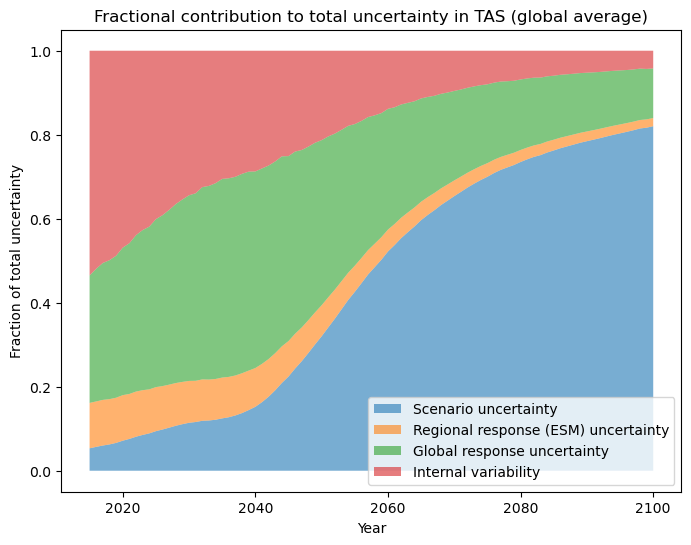

In [16]:
# plotting fractional uncertainty contributions for the global region
sel_region = -1  # global
plt.figure(figsize=(8, 6))

# Calculate fractional contributions
scenario_uncertainty = u_regional_df['var_scenario'].sel(mask=sel_region) / u_regional_df['var_total'].sel(mask=sel_region)
esm_uncertainty = u_regional_df['var_esm'].sel(mask=sel_region) / u_regional_df['var_total'].sel(mask=sel_region)
glob_uncertainty = u_regional_df['var_glob'].sel(mask=sel_region) / u_regional_df['var_total'].sel(mask=sel_region)
int_uncertainty = u_regional_df['var_int'].sel(mask=sel_region) / u_regional_df['var_total'].sel(mask=sel_region)

# Stack the uncertainties
plt.fill_between(u_regional_df['year'], 0, scenario_uncertainty, label='Scenario uncertainty', alpha=0.6)
plt.fill_between(u_regional_df['year'], scenario_uncertainty, scenario_uncertainty + esm_uncertainty, label='Regional response (ESM) uncertainty', alpha=0.6)
plt.fill_between(u_regional_df['year'], scenario_uncertainty + esm_uncertainty, scenario_uncertainty + esm_uncertainty + glob_uncertainty, label='Global response uncertainty', alpha=0.6)
plt.fill_between(u_regional_df['year'], scenario_uncertainty + esm_uncertainty + glob_uncertainty, 1, label='Internal variability', alpha=0.6)

# Add labels and title
plt.title('Fractional contribution to total uncertainty in TAS (global average)')
plt.ylabel('Fraction of total uncertainty')
plt.xlabel('Year')
plt.legend(loc = 'lower right')
plt.show()

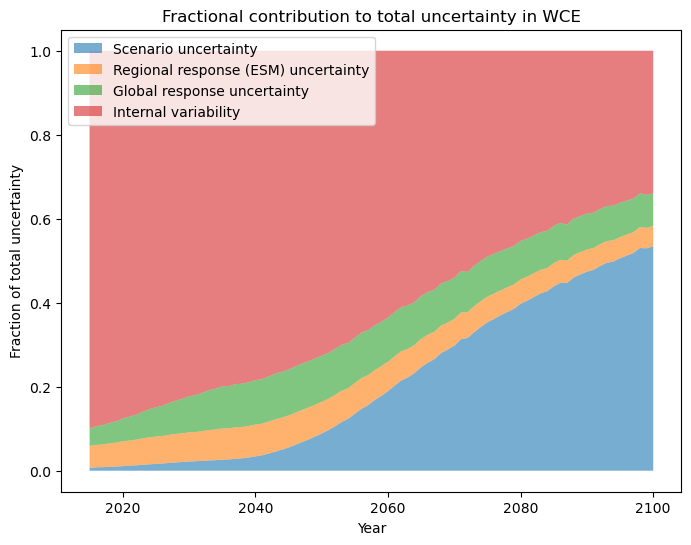

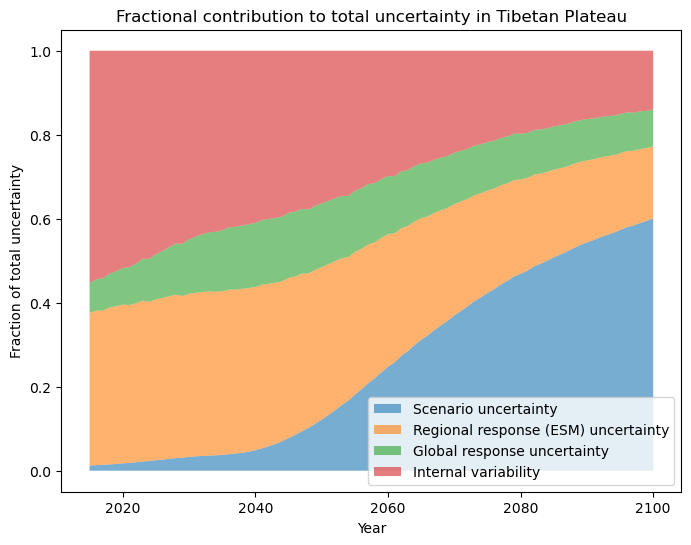

In [17]:
# the resulting plot can vary by region and in, particular,
# the smallter the region, the larger the contribution of internal variability
sel_region = 17  # CENTRAL EUROPE
plt.figure(figsize=(8, 6))

# Calculate fractional contributions
scenario_uncertainty = u_regional_df['var_scenario'].sel(mask=sel_region) / u_regional_df['var_total'].sel(mask=sel_region)
esm_uncertainty = u_regional_df['var_esm'].sel(mask=sel_region) / u_regional_df['var_total'].sel(mask=sel_region)
glob_uncertainty = u_regional_df['var_glob'].sel(mask=sel_region) / u_regional_df['var_total'].sel(mask=sel_region)
int_uncertainty = u_regional_df['var_int'].sel(mask=sel_region) / u_regional_df['var_total'].sel(mask=sel_region)

# Stack the uncertainties
plt.fill_between(u_regional_df['year'], 0, scenario_uncertainty, label='Scenario uncertainty', alpha=0.6)
plt.fill_between(u_regional_df['year'], scenario_uncertainty, scenario_uncertainty + esm_uncertainty, label='Regional response (ESM) uncertainty', alpha=0.6)
plt.fill_between(u_regional_df['year'], scenario_uncertainty + esm_uncertainty, scenario_uncertainty + esm_uncertainty + glob_uncertainty, label='Global response uncertainty', alpha=0.6)
plt.fill_between(u_regional_df['year'], scenario_uncertainty + esm_uncertainty + glob_uncertainty, 1, label='Internal variability', alpha=0.6)

# Add labels and title
plt.title('Fractional contribution to total uncertainty in WCE')
plt.ylabel('Fraction of total uncertainty')
plt.xlabel('Year')
plt.legend(loc = 'upper left')
plt.show()

sel_region = 34  # Tibetan Plateau
plt.figure(figsize=(8, 6))

# Calculate fractional contributions
scenario_uncertainty = u_regional_df['var_scenario'].sel(mask=sel_region) / u_regional_df['var_total'].sel(mask=sel_region)
esm_uncertainty = u_regional_df['var_esm'].sel(mask=sel_region) / u_regional_df['var_total'].sel(mask=sel_region)
glob_uncertainty = u_regional_df['var_glob'].sel(mask=sel_region) / u_regional_df['var_total'].sel(mask=sel_region)
int_uncertainty = u_regional_df['var_int'].sel(mask=sel_region) / u_regional_df['var_total'].sel(mask=sel_region)

# Stack the uncertainties
plt.fill_between(u_regional_df['year'], 0, scenario_uncertainty, label='Scenario uncertainty', alpha=0.6)
plt.fill_between(u_regional_df['year'], scenario_uncertainty, scenario_uncertainty + esm_uncertainty, label='Regional response (ESM) uncertainty', alpha=0.6)
plt.fill_between(u_regional_df['year'], scenario_uncertainty + esm_uncertainty, scenario_uncertainty + esm_uncertainty + glob_uncertainty, label='Global response uncertainty', alpha=0.6)
plt.fill_between(u_regional_df['year'], scenario_uncertainty + esm_uncertainty + glob_uncertainty, 1, label='Internal variability', alpha=0.6)

# Add labels and title
plt.title('Fractional contribution to total uncertainty in Tibetan Plateau')
plt.ylabel('Fraction of total uncertainty')
plt.xlabel('Year')
plt.legend(loc = 'lower right')
plt.show()

#### Second file

In [18]:
# we also want to be able to plot these results by
# scenario if necessary; therefore, please keep
# scenario-specific uncertainty estimates:
regional_uncertainty_singlescenario_file = SCEN_STORING_PATH / f'{sel_scenario}_TAS_REGIONAL_uncertainty.nc' # stored in the scenario-specific folder
u_regional_df = xr.open_dataset(regional_uncertainty_singlescenario_file)

print(u_regional_df)
# the data contains the variances in the temperature
# signal for the ModAct scenario only and by region:
# var_esm: variance due to ESM uncertainty
# var_glob: variance due to global response uncertainty
# var_int: variance due to internal variability
# the data is provided by region (AR6 land regions + global as in 4. & 5)
# note the scenario response uncertainty is missing as the values
# in this dataframe now represent a single scenario only; the cross-scenario
# averages of e.g., var_int were computed as averages over these scenario-specific datasets

<xarray.Dataset> Size: 94kB
Dimensions:   (year: 86, mask: 45)
Coordinates:
  * year      (year) int64 688B 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
  * mask      (mask) float64 360B 0.0 1.0 2.0 3.0 4.0 ... 41.0 42.0 43.0 -1.0
Data variables:
    var_esm   (year, mask) float64 31kB ...
    var_glob  (year, mask) float64 31kB ...
    var_int   (year, mask) float64 31kB ...


In [19]:
# computing the total variance as the sum of the individual variances
u_regional_df['var_total'] = u_regional_df['var_esm'] + u_regional_df['var_glob'] + u_regional_df['var_int']

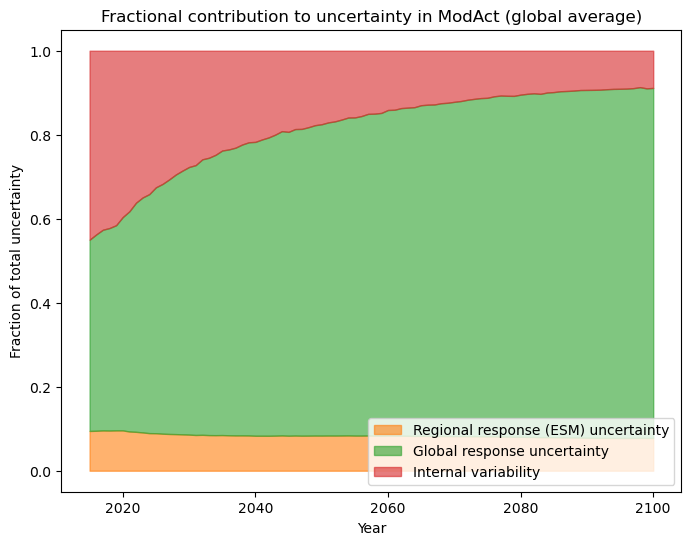

In [20]:
# plotting fractional uncertainty contributions for the global region
sel_region = -1  # global
plt.figure(figsize=(8, 6))

# Calculate fractional contributions
esm_uncertainty = u_regional_df['var_esm'].sel(mask=sel_region) / u_regional_df['var_total'].sel(mask=sel_region)
glob_uncertainty = u_regional_df['var_glob'].sel(mask=sel_region) / u_regional_df['var_total'].sel(mask=sel_region)
int_uncertainty = u_regional_df['var_int'].sel(mask=sel_region) / u_regional_df['var_total'].sel(mask=sel_region)

# Stack the uncertainties without scenario_uncertainty
plt.fill_between(u_regional_df['year'], 0, esm_uncertainty, label='Regional response (ESM) uncertainty', alpha=0.6, color = 'C1')
plt.fill_between(u_regional_df['year'], esm_uncertainty, esm_uncertainty + glob_uncertainty, label='Global response uncertainty', alpha=0.6, color = 'C2')
plt.fill_between(u_regional_df['year'], esm_uncertainty + glob_uncertainty, 1, label='Internal variability', alpha=0.6, color = 'C3')

# Add labels and title
plt.title(f'Fractional contribution to uncertainty in {sel_scenario} (global average)')
plt.ylabel('Fraction of total uncertainty')
plt.xlabel('Year')
plt.legend(loc='lower right')
plt.show()

## 7. Output: Uncertainty decomposition by grid-cell (2 files)
This is the same as in 6., only by grid-cell. 
It contains both scenario-specific and cross-scenario 
files. The dataframe partitions the total uncertainty
in the overall signal into contributions from 
internal variability, regional climate responses (ESM), 
global climate responses, and cross scenario responses. 
The overall idea closely follows  Hawkin & Sutton (10.1175/2009BAMS2607.1) 
and Deser & Lehner (10.1088/2752-5295/accf30). However,
their approach did not distinct between global and regional
responses, so it was slightly adjused. Happy to share our
routine for disentangling these sources.

#### First file

In [23]:
# cross-scenario regional uncertainty dataset
gridcell_uncertainty_crossscenario_file = PATH_SAMPLE_OUTPUT_FASTMIP / f'TAS_GRIDCELL_across-scenario_uncertainty.nc' # stored in the overall output folder as it isn't scenario-specfic
u_gridcell_df = xr.open_dataset(gridcell_uncertainty_crossscenario_file)

print(u_gridcell_df)
# the data contains the variances in the temperature
# signal by gridcell:
# var_scenario: variance due to scenario uncertainty
# var_esm: variance due to ESM uncertainty
# var_glob: variance due to global response uncertainty
# var_int: variance due to internal variability
# the data is provided by region (AR6 land regions + global as in 4. & 5)

<xarray.Dataset> Size: 22MB
Dimensions:       (lat: 56, lon: 143, year: 86)
Coordinates:
  * lat           (lat) float64 448B -53.75 -51.25 -48.75 ... 78.75 81.25 83.75
  * lon           (lon) float64 1kB -178.8 -176.2 -173.8 ... 173.8 176.2 178.8
  * year          (year) int64 688B 2015 2016 2017 2018 ... 2097 2098 2099 2100
Data variables:
    var_scenario  (year, lat, lon) float64 6MB ...
    var_esm       (year, lat, lon) float64 6MB ...
    var_glob      (year, lat, lon) float64 6MB ...
    var_int       (year, lat, lon) float64 6MB ...


In [24]:
# computing the total variance as the sum of the individual variances
u_gridcell_df['var_total'] = u_gridcell_df['var_scenario'] + u_gridcell_df['var_esm'] + u_gridcell_df['var_glob'] + u_gridcell_df['var_int']

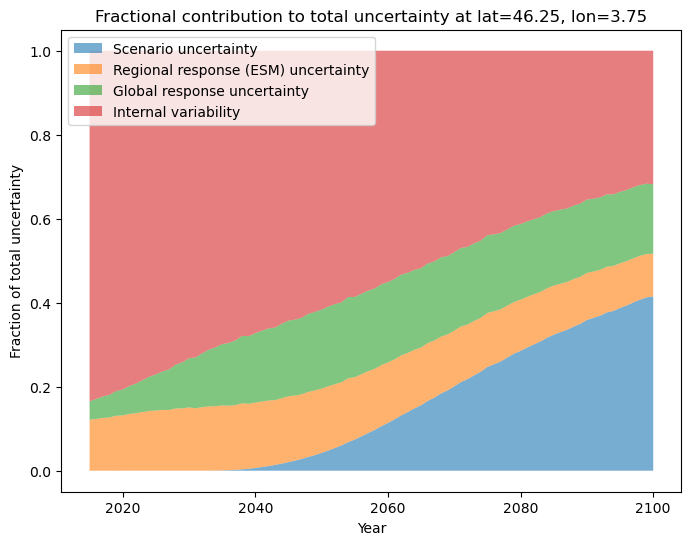

In [27]:
# Generate uncertainty plot for a specific grid-cell
scenario_uncertainty = u_gridcell_df['var_scenario'].sel(lat=sel_lat, lon=sel_lon) / u_gridcell_df['var_total'].sel(lat=sel_lat, lon=sel_lon)
esm_uncertainty = u_gridcell_df['var_esm'].sel(lat=sel_lat, lon=sel_lon) / u_gridcell_df['var_total'].sel(lat=sel_lat, lon=sel_lon)
glob_uncertainty = u_gridcell_df['var_glob'].sel(lat=sel_lat, lon=sel_lon) / u_gridcell_df['var_total'].sel(lat=sel_lat, lon=sel_lon)
int_uncertainty = u_gridcell_df['var_int'].sel(lat=sel_lat, lon=sel_lon) / u_gridcell_df['var_total'].sel(lat=sel_lat, lon=sel_lon)

# Plot the fractional contributions
plt.figure(figsize=(8, 6))

# Stack the uncertainties
plt.fill_between(u_gridcell_df['year'], 0, scenario_uncertainty, label='Scenario uncertainty', alpha=0.6)
plt.fill_between(u_gridcell_df['year'], scenario_uncertainty, scenario_uncertainty + esm_uncertainty, label='Regional response (ESM) uncertainty', alpha=0.6)
plt.fill_between(u_gridcell_df['year'], scenario_uncertainty + esm_uncertainty, scenario_uncertainty + esm_uncertainty + glob_uncertainty, label='Global response uncertainty', alpha=0.6)
plt.fill_between(u_gridcell_df['year'], scenario_uncertainty + esm_uncertainty + glob_uncertainty, 1, label='Internal variability', alpha=0.6)

# Add labels and title
plt.title(f'Fractional contribution to total uncertainty at lat={sel_lat}, lon={sel_lon}')
plt.ylabel('Fraction of total uncertainty')
plt.xlabel('Year')
plt.legend(loc='upper left')
plt.show()

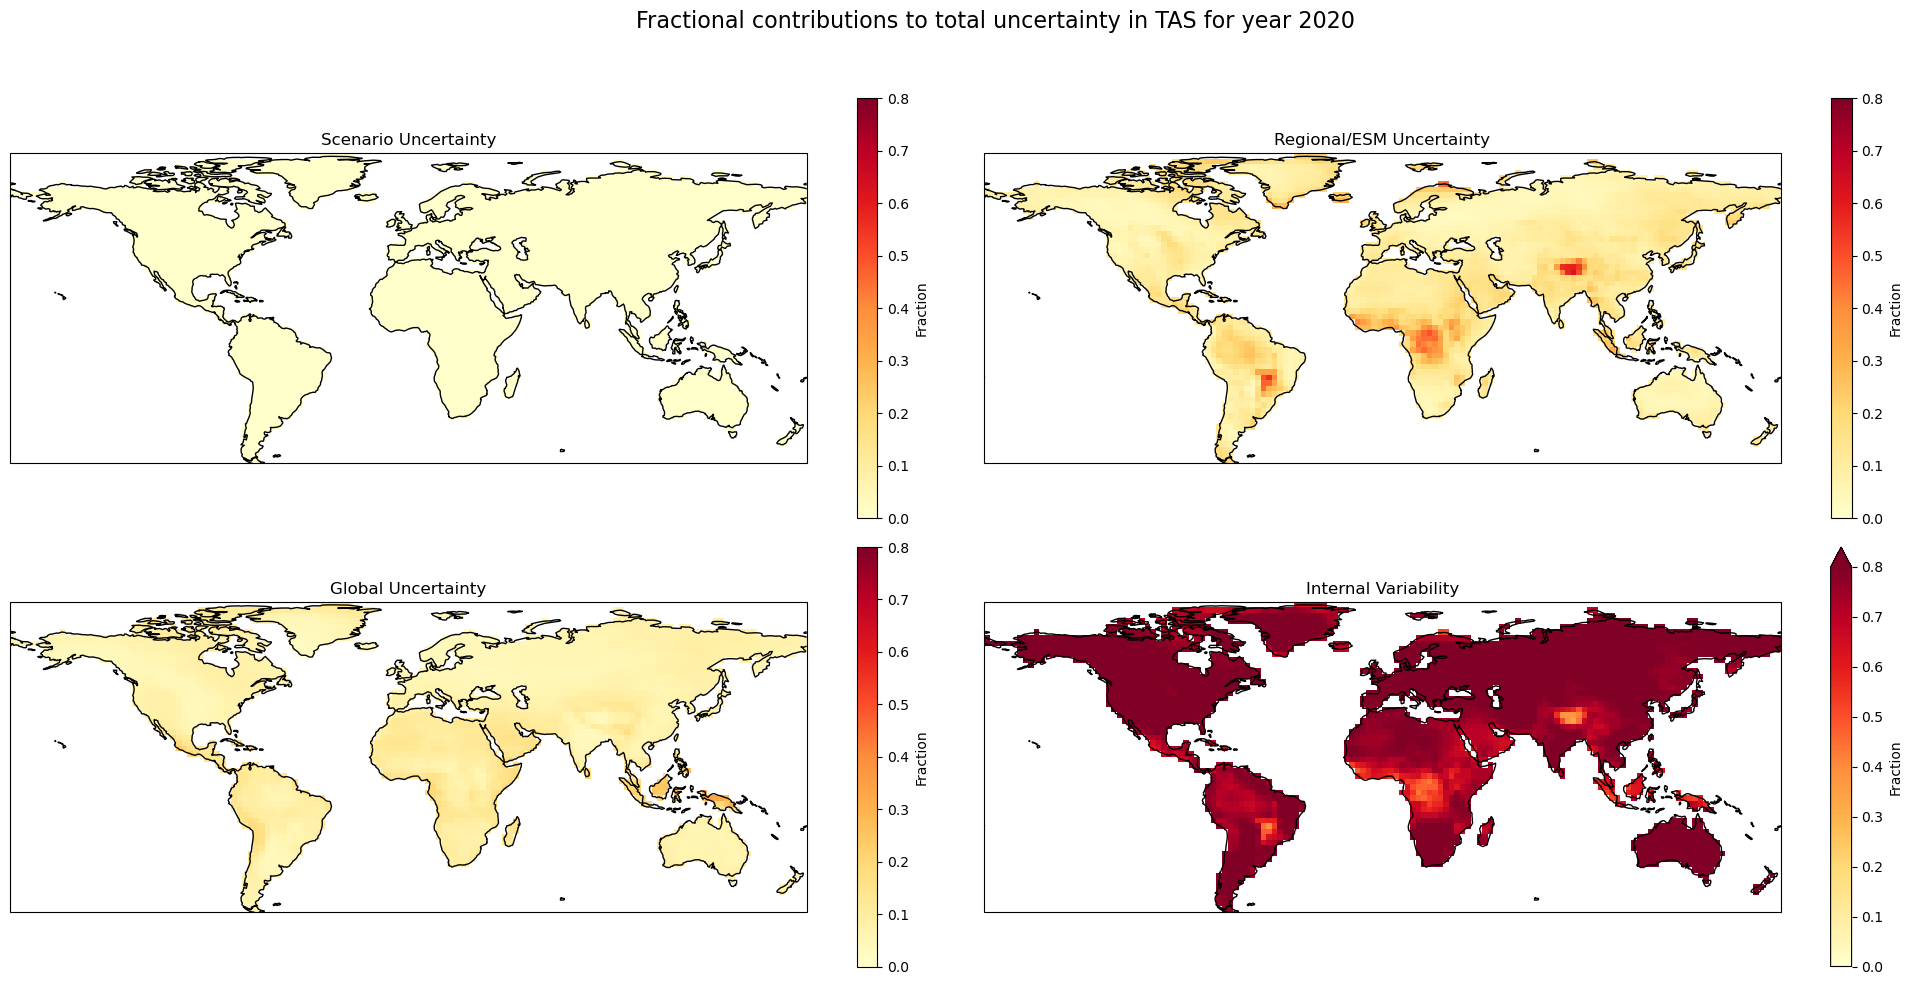

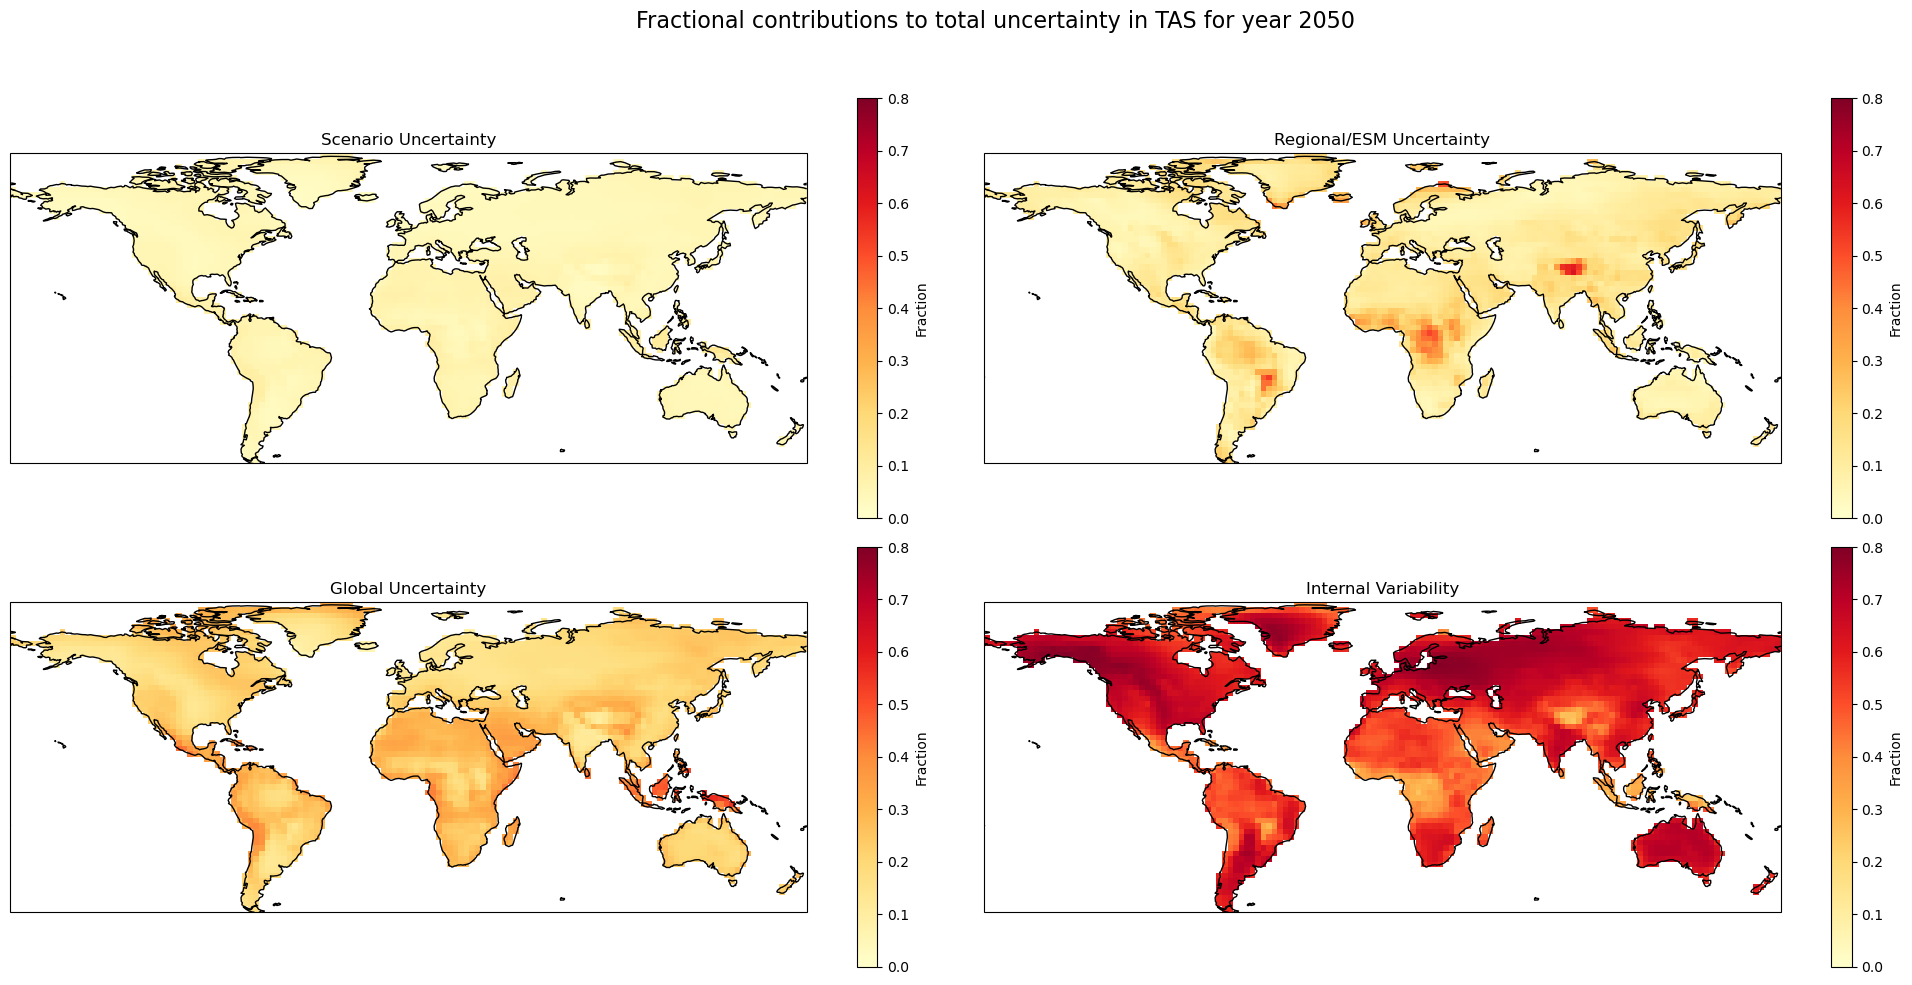

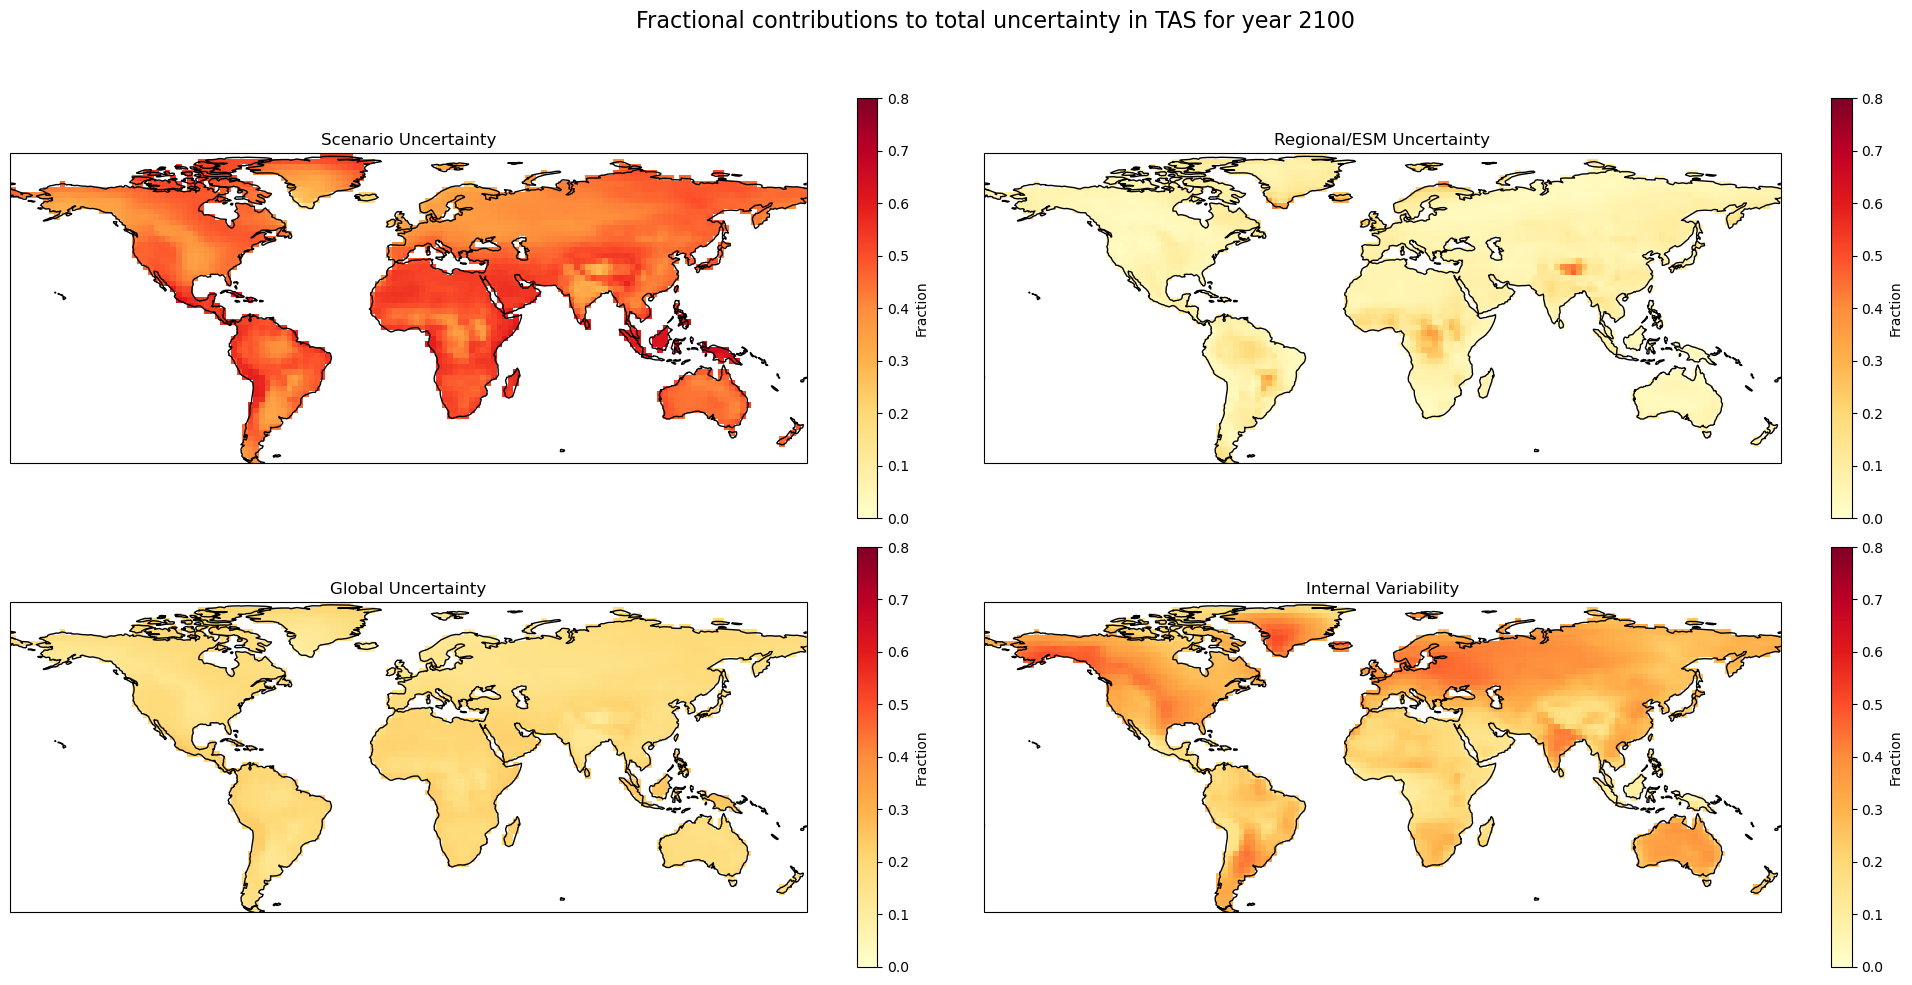

In [29]:
# we can use the grid-cell level data to plot contributions on
# a map and investigate how these maps evolve over time
for sel_year in [2020, 2050, 2100]:
    fig, axes = plt.subplots(2, 2, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    fractional_contributions = ['var_scenario', 'var_esm', 'var_glob', 'var_int']
    titles = ['Scenario Uncertainty', 'Regional/ESM Uncertainty', 'Global Uncertainty', 'Internal Variability']
    cmaps = ['YlOrRd']*4

    for ax, var, title, cmap in zip(axes.flat, fractional_contributions, titles, cmaps):
        data = (u_gridcell_df[var].sel(year=sel_year) / u_gridcell_df['var_total'].sel(year=sel_year))
        data.plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            vmin=0,
            vmax=0.8,
            cbar_kwargs={"label": "Fraction"}
        )
        ax.coastlines()
        ax.set_title(title)

    fig.suptitle('Fractional contributions to total uncertainty in TAS for year ' + str(sel_year), fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the suptitle
    plt.show()

#### Second file

In [ ]:
# we also want to be able to plot these results by
# scenario if necessary; therefore, please keep
# scenario-specific uncertainty estimates also at the gridcell level:
gridcell_uncertainty_singlescenario_file = SCEN_STORING_PATH / f'{sel_scenario}_TAS_GRIDCELL_uncertainty.nc' # stored in the scenario-specific folder
u_gridcell_df = xr.open_dataset(gridcell_uncertainty_singlescenario_file)

print(u_gridcell_df)
# the data contains the variances in the temperature
# signal for the ModAct scenario only and by rgridcell:
# var_esm: variance due to ESM uncertainty
# var_glob: variance due to global response uncertainty
# var_int: variance due to internal variability
# the data is provided by gridcell; note the scenario
# response uncertainty is missing as the values in this
# dataframe now represent a single scenario only;
# the cross-scenario averages of e.g., var_int were
# computed as averages over these scenario-specific
# datasets

<xarray.Dataset> Size: 17MB
Dimensions:   (lat: 56, lon: 143, year: 86)
Coordinates:
  * lat       (lat) float64 448B -53.75 -51.25 -48.75 ... 78.75 81.25 83.75
  * lon       (lon) float64 1kB -178.8 -176.2 -173.8 ... 173.8 176.2 178.8
  * year      (year) int64 688B 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
Data variables:
    var_esm   (year, lat, lon) float64 6MB ...
    var_glob  (year, lat, lon) float64 6MB ...
    var_int   (year, lat, lon) float64 6MB ...


### GRID-CELL LEVEL UNCERTAINTIES

In [32]:
### GRIDCELL-LEVEL UNCERTAINTY DECOMPOSITION
u_gridcell_df = xr.open_dataset(gridcell_uncertainty_singlescenario_file)
u_gridcell_df['var_total'] = u_gridcell_df['var_esm'] + u_gridcell_df['var_glob'] + u_gridcell_df['var_int'] # the sum is now missing var scenario

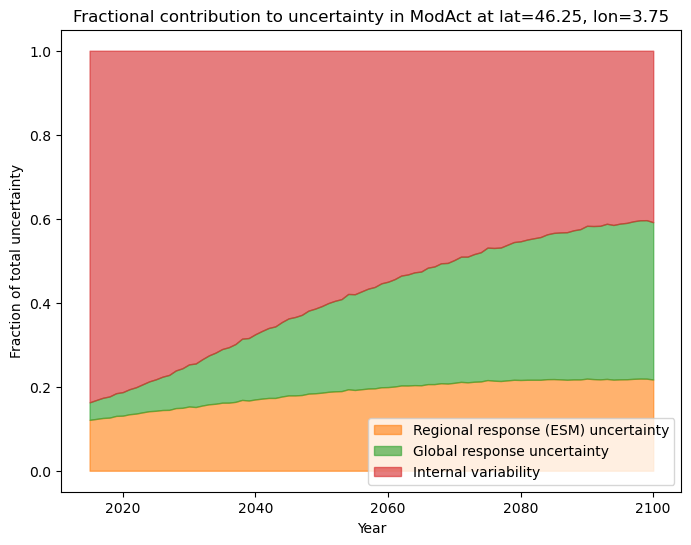

In [33]:
# Plotting fractional uncertainty contributions for the selected latitude and longitude
plt.figure(figsize=(8, 6))

# Calculate fractional contributions
esm_uncertainty = u_gridcell_df['var_esm'].sel(lat=sel_lat, lon=sel_lon) / u_gridcell_df['var_total'].sel(lat=sel_lat, lon=sel_lon)
glob_uncertainty = u_gridcell_df['var_glob'].sel(lat=sel_lat, lon=sel_lon) / u_gridcell_df['var_total'].sel(lat=sel_lat, lon=sel_lon)
int_uncertainty = u_gridcell_df['var_int'].sel(lat=sel_lat, lon=sel_lon) / u_gridcell_df['var_total'].sel(lat=sel_lat, lon=sel_lon)

# Stack the uncertainties without scenario_uncertainty
plt.fill_between(u_gridcell_df['year'], 0, esm_uncertainty, label='Regional response (ESM) uncertainty', alpha=0.6, color='C1')
plt.fill_between(u_gridcell_df['year'], esm_uncertainty, esm_uncertainty + glob_uncertainty, label='Global response uncertainty', alpha=0.6, color='C2')
plt.fill_between(u_gridcell_df['year'], esm_uncertainty + glob_uncertainty, 1, label='Internal variability', alpha=0.6, color='C3')

# Add labels and title
plt.title(f'Fractional contribution to uncertainty in {sel_scenario} at lat={sel_lat}, lon={sel_lon}')
plt.ylabel('Fraction of total uncertainty')
plt.xlabel('Year')
plt.legend(loc='lower right')
plt.show()